# Tutorial 1 - Limits to growth in World3: A toy world model of diminishing non-renewable resources

Week 2, Day 3: IPCC Socio-economic Basis

By Neuromatch Academy

Content creators: Maximilian Puelma Touzel

Content reviewers: Name Surname, Name Surname

Content editors: Name Surname, Name Surname

Production editors: Name Surname, Name Surname

Our 2023 Sponsors

---
# Tutorial Objectives
Learn about nonlinear, coupled dynamics of various aggregated world system variables in `World3`, one of the first toy world models that combined economic activity and the effects it has on the natural world.

---
# Setup

Import libaries

In [1]:
from IPython.display import Math
from IPython.display import display, HTML, Image
import seaborn as sns
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
import pooch
import urllib

figure settings

In [2]:
sns.set_style("ticks", {'axes.grid': False})
%matplotlib inline
display(HTML("<style>.container { width:100% !important; }</style>"))
params = {'lines.linewidth': '3'}
pl.rcParams.update(params)

In [3]:
#@title Figure functions
def get_IPCC_data(var_name, path):
    IAMdf = pd.read_excel(path)
    IAMdf.drop(IAMdf.tail(2).index,inplace = True)  # excel file has 2 trailing rows of notes 
    IAMdf.drop(['Model','Region','Variable','Unit','Notes'],axis=1,inplace =True) #remove columns we won't need

    # The data is in wideform (years are columns). 
    # Longform (year of each datum as a column) is more convenient. 
    # To collapse it to longform we'll use the `pd.wide_to_long` method that requires the following reformatting 
    IAMdf.rename(columns=dict(zip(IAMdf.columns[1:],[var_name+str(y) for y in IAMdf.columns[1:]])),inplace=True) #add 'pop' to the year columns to tell the method which columns to map
    IAMdf.index = IAMdf.index.set_names(['id']) #name index
    IAMdf=IAMdf.reset_index() #make index a column
    IAMdf=pd.wide_to_long(IAMdf, [var_name], i='id', j="year")

    IAMdf=IAMdf.reset_index().drop('id',axis=1) #do some post mapping renaming
    IAMdf.year=IAMdf.year.apply(int) #turn year data from string to int
    if var_name=='pop':
        IAMdf[var_name]=1e6*IAMdf[var_name] #pop is in millions
    elif var_name=='CO2':
        IAMdf[var_name]=1e6*IAMdf[var_name] #CO2 is in Mt CO2/yr
    elif var_name=='forcing':
        IAMdf=IAMdf # forcing in W/m2
    return IAMdf

def run_and_plot(world3, nri_factor=1, new_lifetime_industrial_capital=14):
    # nonrenewable resources initial [resource units]
    world3.init_world3_constants(
        nri=nri_factor*1e12, alic1=14, alic2=new_lifetime_industrial_capital)
    world3.init_world3_variables()
    world3.set_world3_table_functions()
    world3.set_world3_delay_functions()
    world3.run_world3(fast=False)

    # select model variables to plot
    variables = [world3.nrfr, world3.iopc, world3.fpc,
                 world3.pop, world3.ppolx, world3.d, world3.cdr]
    variable_labels = ["NRFR",  # nonrenewable resource fraction remaining
                       # industrial output per capita [dollars/person-year]
                       "IOPC",
                       # food production per capita [vegetable-equivalent kilograms/person-year]
                       "FPC",
                       "POP",  # population [persons]
                       "PPOLX",  # index of persistent pollution
                                # (fraction of peristent pollution in 1970 = 1.36e8 pollution units)
                       "deaths",
                       "deathrate\n/1000"]
    variable_limits = [[0, 1], [0, 1e3], [0, 1e3], [
        0, 16e9], [0, 32], [0, 5e8], [0, 250]]  # y axis ranges

    plot_world_variables(world3.time, variables, variable_labels, variable_limits,
                         img_background=None,  # ./img/fig7-7.png",
                         figsize=[4+len(variables), 7],
                         title="initial non-renewable resources=" + \
                         str(nri_factor)+"*1e12",
                         grid=True)

    # overlay an SSP projection
    scenario_name='SSP2-Baseline'
    pop_path = pooch.retrieve('https://osf.io/download/ed9aq/',known_hash=None)
    IAMpopdf=get_IPCC_data('pop', pop_path)
    year_data = IAMpopdf.loc[IAMpopdf.Scenario==scenario_name,'year']
    var_data = IAMpopdf.loc[IAMpopdf.Scenario==scenario_name,'pop']
    axs = pl.gcf().axes
    axs[variable_labels.index('POP')].plot(year_data,var_data, 'r--', label=scenario_name)
    axs[variable_labels.index('POP')].legend(frameon=False)

# Section 1: Peak at the IPCCs Socioeconomic projections

In subsequent tutorials, we will play with Integrated Assessment Models, the standard class of models used to make climate change projections. 

Here, let's start by just looking at some of their model output to motivate us looking at `World3` which gives similar socioeconomic output.

All data from the main simulations of the IAMs used in the IPCC reports is freely available for viewing at https://tntcat.iiasa.ac.at/.
If you give them only an email, you can download any data you select. I downloaded 
- world population, 
- total CO<sub>2</sub> emissions (harmonized), and
- climate forcing

The files all download with the same name, `iamc_db.xlsx`, so I appended '_pop','_CO2', and '_forcing' to distinguish them. Let's load and plot that data here using a plotting function that you don't need to understand, which is defined in the plotting functions section above.

SHA256 hash of downloaded file: 6cb9ecdcc8cd89e6b2c6438ed0f60a9afe4791e6fc4190b3a190da32242897a0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/Users/wesleybanfield/miniconda3/envs/pangeo/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
SHA256 hash of downloaded file: 8ebe2fb8e0085e4382ff49dc1a68c6aca619d4490a0c8853c75c0d2e6db621e3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/Users/wesleybanfield/miniconda3/envs/pangeo/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
SHA256 has

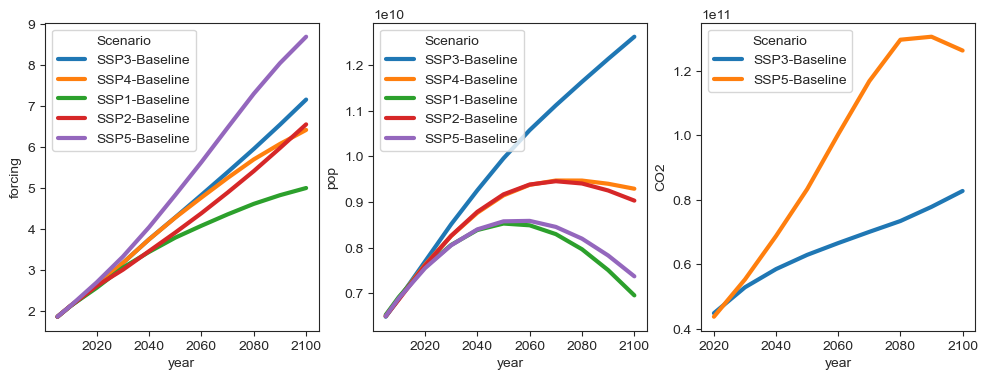

In [4]:
var_names = ['forcing','pop','CO2']
paths = ['https://osf.io/download/tkrf7/', 'https://osf.io/download/ed9aq/','https://osf.io/download/gcb79/'] 
axis_size=4
fig,ax=pl.subplots(1,len(var_names),figsize=(axis_size*len(var_names),axis_size))
for ax_idx,var_name in enumerate(var_names):
    path = pooch.retrieve(paths[ax_idx],known_hash=None)
    data_df=get_IPCC_data(var_name, path)
    sns.lineplot(ax=ax[ax_idx],data=data_df,x='year',y=var_name,hue='Scenario') # plot the data

So far you have seen how forcing as an input to a climate model leads to temperature increases and other climate effects like changes in precipitation.
The IAM projections that use these forcings profiles feed the temperature effects into a socioeconomic model component that evolves our population and the amount of emissions we produce consistent with the forcing for that scenario. There are 5 main scenarios (called *socioeconomic pathways*) that the IPCC considers (that's what the different colors are in the above plots). We'll get into all those details in a subsequent tutorial. 

# Section 2: World Models and World3
Here, we want to step back from IAMs and use another model class, world models, to first explore how socioeconomic system variables like population, capital and pollution co-evolve. 

*   World models are another modelling tradition separate from the policy optimization found in an Integrated Assessment Model. 
*   World models are literally that, a model of the world in which all variables are endogeneous, *i.e.* the model is self-contained and simply runs as a dynamical system, i.e. given equations of rates of change of the variables and an initial condition to start them from.
*   The important variables in a world model are similar to those of Integrated Assessment Models: capital, production, population, pollution etc. 
*   `World3` is a world model that was developed in the 1970s and doesn't have an explicit climate component (perhaps its developers were unaware of climate change at the time, as many were back then). 
*   `World3` does have a *pollution* variable that is driven by industrial activity, and this pollution negatively impacts food production and directly increases mortality rates via health effects.
*   If we were developing `World3` today with our knowledge of human-driven climate change, we would add greenhouse gas emissions as a component of the pollution variable, which is the place in `World3` representing the damaging waste of our industrial activity.  
*   The reason we are looking at `World3` here in this first tutorial, is that:
1.  `World3` is a instructive world model of the resource depletion and pollution problem. These problems are prior to climate change in that they encapsulate it, and understanding them helps us understand the socioeconomic forces at work in driving the emissions that are the source of the climate change problem.
2. World models provide an alternative modelling tradition not steeped in the neoclassical economics on which IAMs are based. This provides some diversity in perspective.
*   N.B. the model is not only wrong (i.e. missing many variables), but is a poor idealization, i.e. not necessarily even qualitatively predictive because it is missing some determining variables/model features (e.g. technology innovation/adaptation). It is thus almost certainly not predictive, but is still useful in starting to think about 'world systems' because it includes important relationships between some important natural and socio-economic variables that we will look at here. To be fair, one could also criticize IAMs for lacking important variables, as we will see in future tutorials.

OKay, so welcome to World3! Here's a stock-flow diagram of the full model:

In [5]:
display(Image(url="https://osf.io/download/hzrsn/", width=1000, unconfined=True))
# copyrighted image from the textbook:
# Meadows, D.L.; Behrens, W.W.; Meadows, D.L.; Naill, R.F.; Randers, J.; Zahn, E.K.O. The Dynamics of Growth in a Finite World; Wright-Allen Press: Cambridge, MA, USA, 1974.
# Source: https://www.mdpi.com/sustainability/sustainability-07-09864/article_deploy/html/images/sustainability-07-09864-g001.png
# Alternate image from the precursor model: Jay Forrester's world dynamic model: https://petterholdotme.files.wordpress.com/2022/04/world-dynamics.png

WOw! that's a lot of variables!

*Exercise*: increase width to 3000 and scroll around to read the node labels of the different parts of the model. Can you group them into broader categories?

Here is a reduced diagram containing only some major variables and thier couplings:

In [6]:
display(Image(url="https://osf.io/download/h3mj2/", width=250))
#modified from another copyrighted image from Limits To Growth (1972, page 97). This woudl be easy to reproduce

Follow the dependencies. E.g. industrial capital grows wtih investment and produces industrial output that generates pollution and argicultural capital. Along with cultivated land, the latter generate food. Increasing pollution and decreasing (-) food per capita drive up mortality, which decreases population via the deaths per year, while fertility increases population via births per year.

# Section 3: Pyworld3

We'll be using a nice python implementation of this model called `pyworld3` that is openly accessible: https://github.com/cvanwynsberghe/pyworld3.

In [7]:
# !pip install pyworld3
# # if running locally (i.e. into in collab) run this instead:
# import sys
# !{sys.executable} - m pip install pyworld3

load the model

In [8]:
from pyworld3 import World3
from pyworld3.utils import plot_world_variables

We've defined a useful plotting function that we will use that has two inputs we will vary: 
- the initial amount of non-renewable resources (`nri_factor`), and 
- a perturbed value of the lifetime of industrial capital to which the system will be perturbed at the perturbation year (`new_lifetime_industrial_capital`)

Let's also set the year up to which we want to run the simulations

In [9]:
maxyear = 2100

## Case 1: original (Business-As-Usual - BAU) model parameters

/Users/wesleybanfield/miniconda3/envs/pangeo/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


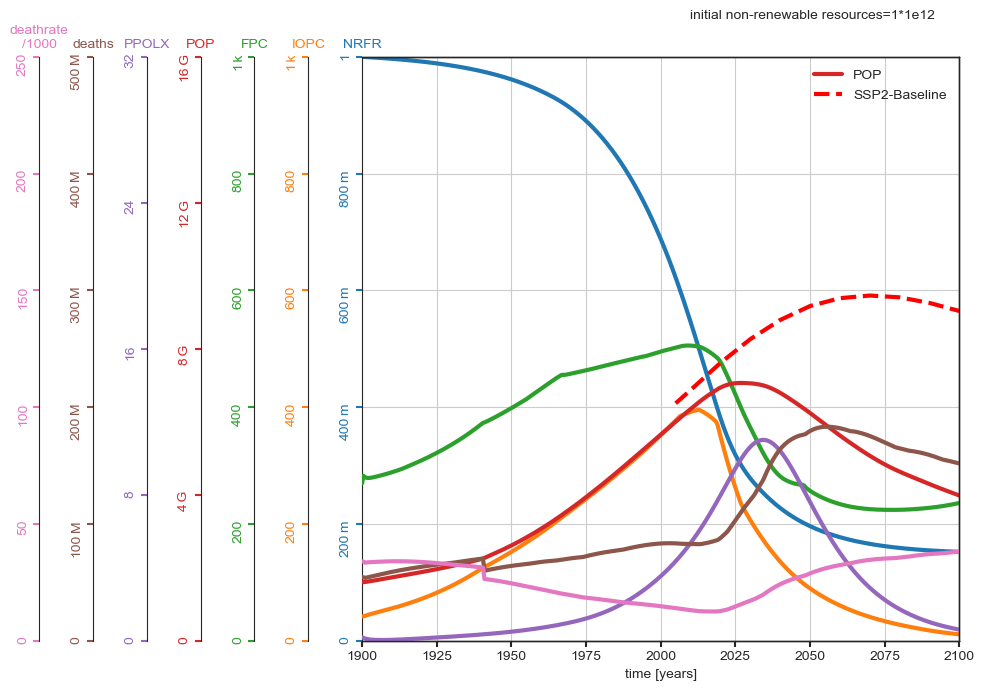

In [10]:
world3 = World3(year_max=maxyear)
run_and_plot(world3)
# pl.savefig("world3_timeseries_case_1.png",transparent=True,bbox_inches="tight",dpi=300)

Observe how industrial output (rising orange), food per capita (rising green), and population (rising red) grow until diminishing non-renewable resources (falling blue) drive a fall in industrial production (falling orange). 

This tanks food production (falling green) and medical services which reverses the decreasing death rate trend (pink) and drops the population (falling red) over the second half of the 21st century.

Here, the population projection for IPCC baseline scenario for SSP2 is shown as the red dashed line.

## Case 2: BAU3 - increased efficiency

*Exercise*: Now, triple the initial resources, modelling the effect of increased efficiency in resource extraction (e.g. crop yields, as has been observed over the last decades, or "learning-by-doing" effect seen in the economics of many energy technologies)

/Users/wesleybanfield/miniconda3/envs/pangeo/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


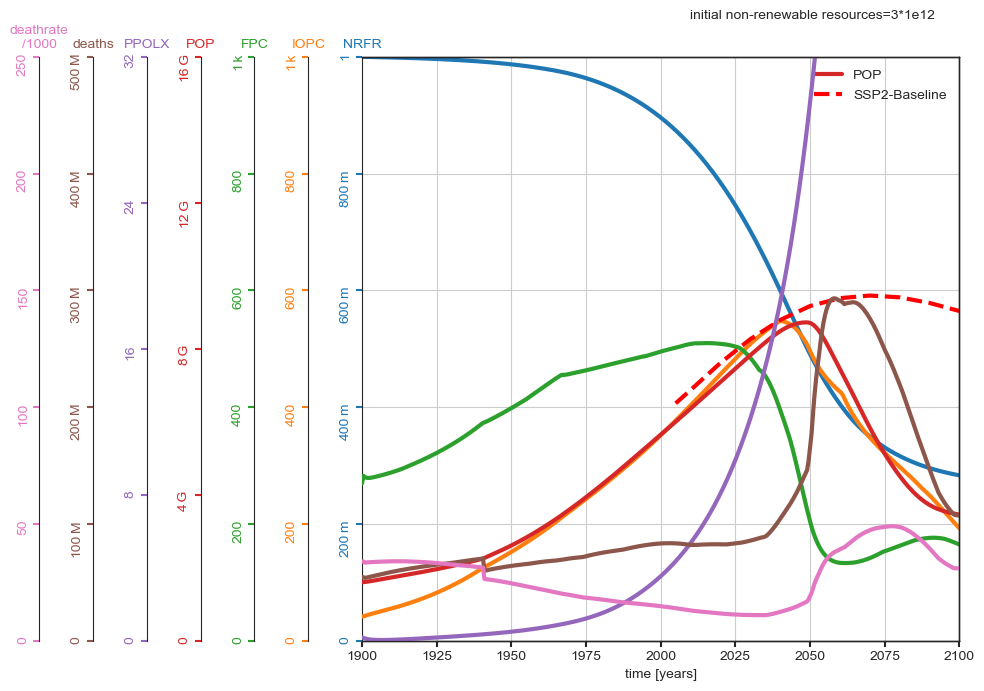

In [11]:
run_and_plot(world3, nri_factor=3)
# pl.savefig("world3_timeseries_case_2.png",transparent=True,bbox_inches="tight",dpi=300)

Observe that the crash in industrial output still occurs for this larger resource pool, only now delayed (here by a few decades). Unlike the previous case, soaring pollution (purple) from those extra decades of exponential industrial output precipitates a faster and larger (relative to case 1) population crash starting mid-century.

## Case 3: BAU3 with active cap on production

*Exercise*: Turn down production abruptly via a step decrease in the lifetime of industrial capital (from 14 to 8 years occuring at 2025).
(see Rozenberg et al. *Environ. Res. Lett.* (2015) for an IAM analysis of transitioning with reductions in lifetime capital)

/Users/wesleybanfield/miniconda3/envs/pangeo/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


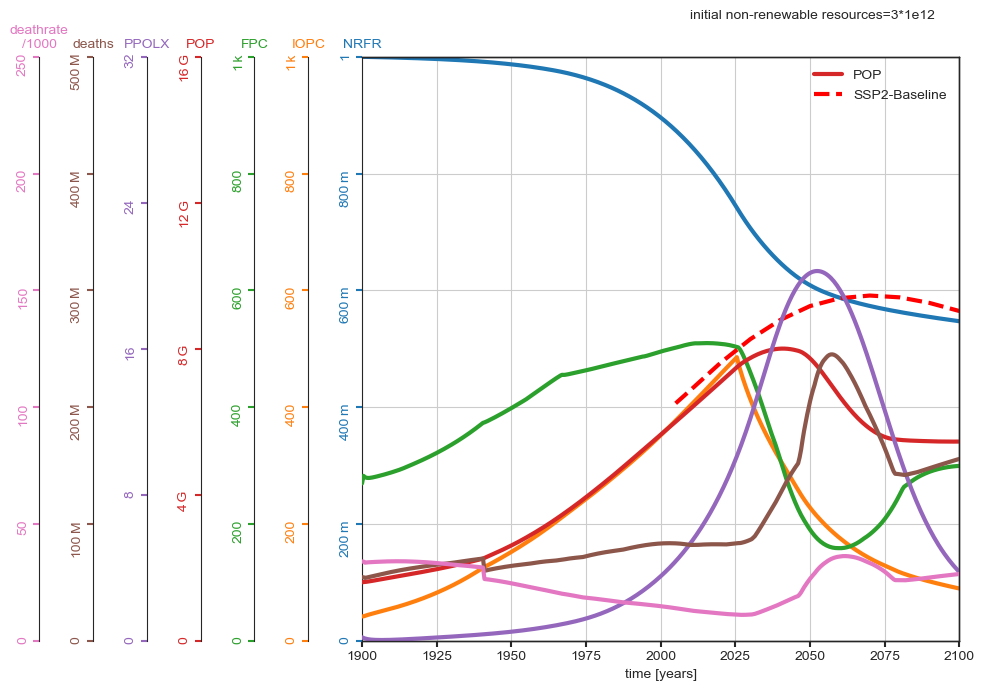

In [12]:
world3 = World3(pyear=2025, year_max=2100)
run_and_plot(world3, nri_factor=3, new_lifetime_industrial_capital=8)
# pl.savefig("world3_timeseries_case_3.png",transparent=True,bbox_inches="tight",dpi=300)

Observe that turning down production limits pollution, which limits the drop in population to a (transient) plateau and leaves intact a significant amount of non-renewable resources (e.g. ecosystems). However, the asymptotic death rate eventually creeps up to that of case 2.

Dropping industrial output affects our ability to develop new technologies, e.g. those needed for decarbonization (c.f. the article *Decarbonizing the downturn: Addressing climate change in an age of stagnation* by Copley et al. *Competition & Change*, 2022). This stagnation scenario is a central challenge we face in the narrative of Shared Socio-economic Pathway 3 (SSP3 *Regional Rivary*).

Activity Questions:
- What scenarios can you think of that would lead to such a drop in the lifetime of industrial capital?
- What are some important features of the world/society/the economy that you think this model is missing? Do you have ideas for how to implement them here?

Model Limitations
- no spatial structure: spatial structure is important! (allows for distinct regional solutions that aid or hinder global cooperation, c.f. emergence of cooperation in game theory).
- ignores technology innovation, in particular that focussed on adaptation and mitigation
- *ad hoc* setting of relationship between economic growth, investment in health services, and changes in life expectancy
- only includes a monolithic non-renewable resource (e.g. doesn't breakdown the resource into renewable & nonrenewable classes)
- ...probably lots more!

---
# Appendix

For easy reference, here is the validity analyses presented in the pyworld3 github repository. These are standard parameter runs of the model overlayed with those of original implementation to show validity of the `pyworld3` package implementation

In [13]:
world3 = World3()
# nonrenewable resources initial [resource units]
world3.init_world3_constants()
world3.init_world3_variables()
world3.set_world3_table_functions()
world3.set_world3_delay_functions()
world3.run_world3(fast=False)

SHA256 hash of downloaded file: 6889af15480a711e334960a50522b92d0980d2d1d3269ade99e28db6377c1b90
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


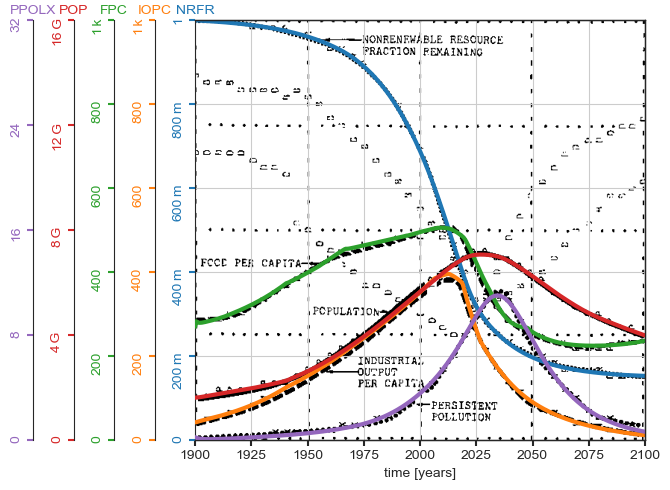

In [14]:
plot_world_variables(world3.time,
                     [world3.nrfr, world3.iopc, world3.fpc, world3.pop,
                      world3.ppolx],
                     ["NRFR", "IOPC", "FPC", "POP", "PPOLX"],
                     [[0, 1], [0, 1e3], [0, 1e3], [0, 16e9], [0, 32]],
                     img_background=pooch.retrieve("https://osf.io/download/r4npd/",known_hash=None),
#                      img_background=urllib.request.urlopen("https://osf.io/download/r4npd/"),
#                      img_background=data_dir+"fig7-7.png",
                     figsize=(7, 5),
                     title=None,
                     grid=True)

SHA256 hash of downloaded file: 6167072699922f2c81004f3b0471916062620d2ba344a3ffaff783b2edaeedcb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


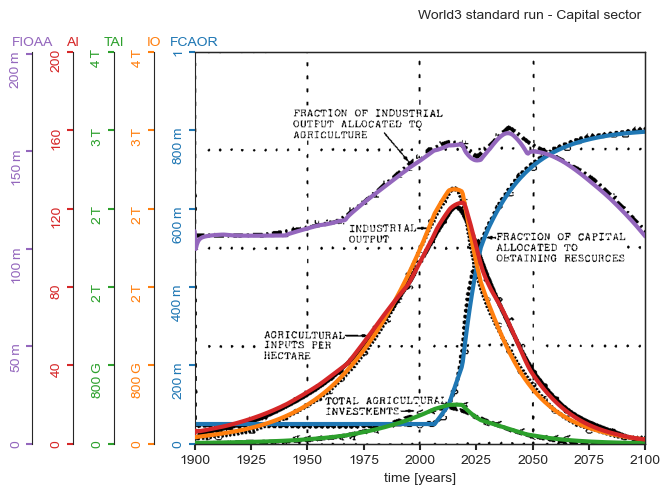

In [15]:
plot_world_variables(world3.time,
                     [world3.fcaor, world3.io, world3.tai, world3.aiph,
                      world3.fioaa],
                     ["FCAOR", "IO", "TAI", "AI", "FIOAA"],
                     [[0, 1], [0, 4e12], [0, 4e12], [0, 2e2], [0, 0.201]],
                     img_background=pooch.retrieve("https://osf.io/download/d6gz2/",known_hash=None),
                     figsize=(7, 5),
                     title="World3 standard run - Capital sector")

SHA256 hash of downloaded file: 60e6c9cd2f5a5656fa1b01812f603cbda3a2431da75826fc163790cd9300cfba
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


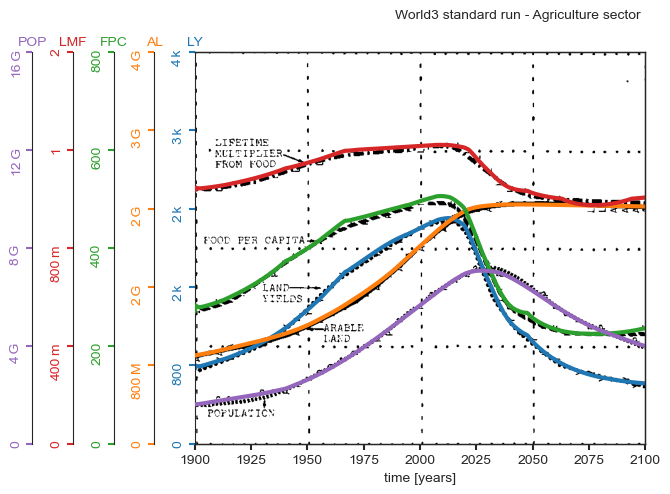

In [16]:
plot_world_variables(world3.time,
                     [world3.ly, world3.al, world3.fpc, world3.lmf,
                      world3.pop],
                     ["LY", "AL", "FPC", "LMF", "POP"],
                     [[0, 4e3], [0, 4e9], [0, 8e2], [0, 1.6], [0, 16e9]],
                    img_background=pooch.retrieve("https://osf.io/download/t2qdm/",known_hash=None),
                     figsize=(7, 5),
                     title="World3 standard run - Agriculture sector")